## 4.Problem Statement : find the future demand of Parker Pens from the previous Data.

### Stretegy : Apply ARIMA model for forecasing the result.

### Data : 14 years monthly data of demand of parker pens from all stores of the company. 

In [78]:
import datetime as dt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

### Data preparetion for Time Series Data

In [79]:
df_demand=pd.read_excel('C:/datalake/project_retail/master_dataset.xlsx', sheet_name='demand_data',encoding = 'unicode_escape')
df_demand['Month'] =df_demand['Month'].astype(str)
df_demand['Month']= df_demand["Month"].str.split(" ", n = 1, expand = True) 
df_demand['Month']=pd.to_datetime(df_demand['Month'])
df_demand.set_index('Month',inplace=True)
df_demand.head()

,pen_demamd
Month,
2002-01-01,589
2002-02-01,561
2002-03-01,640
2002-04-01,656
2002-05-01,727


In [80]:

y = df_demand['pen_demamd'].resample('MS').mean()

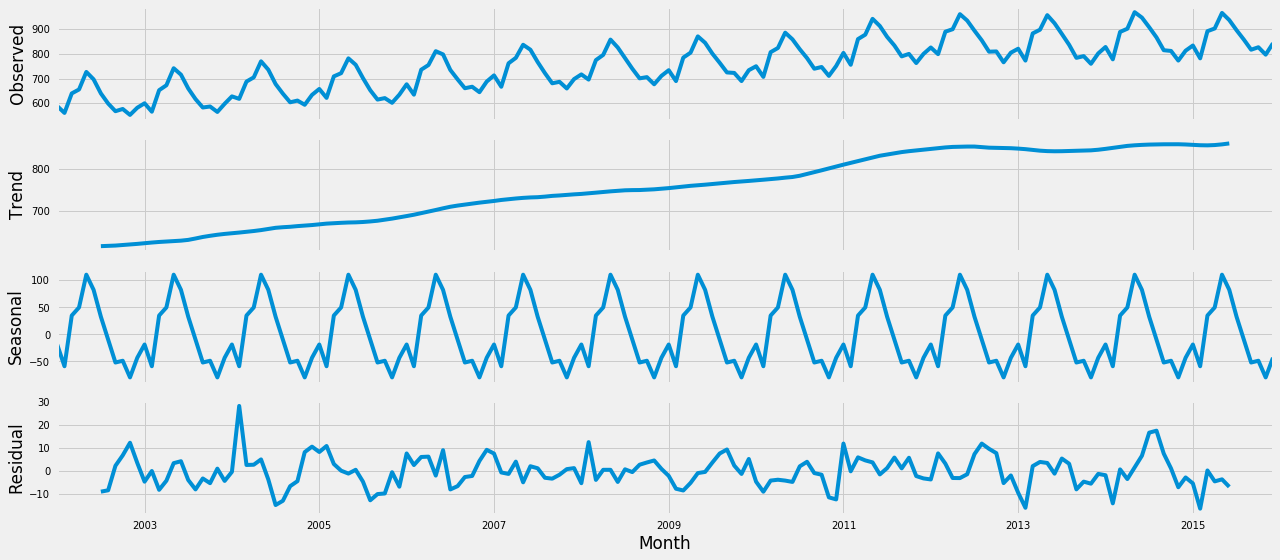

In [81]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Visualize Time Series Data

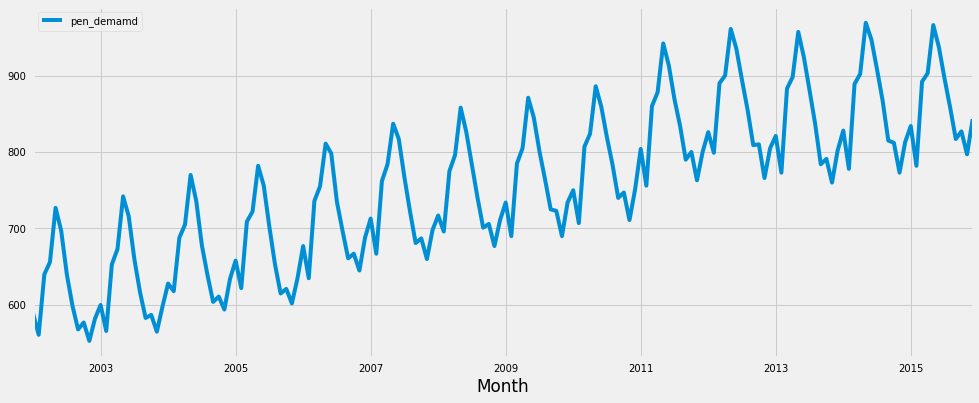

In [82]:
df_demand.plot(figsize=(15, 6))

### Testing Stationarity of Data

In [83]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df_demand['pen_demamd'])
# dk fullar test for stationarity

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [84]:
adfuller_test(df_demand['pen_demamd'])

ADF Test Statistic : -1.3038115874221294
p-value : 0.6274267086030316
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### rejected null hypothesis (>0.05)

In [85]:
df_demand['Sales First Difference'] = df_demand['pen_demamd'] - df_demand['pen_demamd'].shift(1)
df_demand.head(3)

,pen_demamd,Sales First Difference
Month,,
2002-01-01,589,NaN
2002-02-01,561,-28.0
2002-03-01,640,79.0


In [86]:
df_demand['pen_demamd'].shift(1)
df_demand.head(3)

,pen_demamd,Sales First Difference
Month,,
2002-01-01,589,NaN
2002-02-01,561,-28.0
2002-03-01,640,79.0


In [87]:
df_demand['Seasonal First Difference']=df_demand['pen_demamd']-df_demand['pen_demamd'].shift(4)
df_demand.head(4)

,pen_demamd,Sales First Difference,Seasonal First Difference
Month,,,
2002-01-01,589,NaN,NaN
2002-02-01,561,-28.0,NaN
2002-03-01,640,79.0,NaN
2002-04-01,656,16.0,NaN


In [88]:
## Again test dickey fuller test
adfuller_test(df_demand['Seasonal First Difference'].dropna())

ADF Test Statistic : -3.0969072216395346
p-value : 0.02678291617128674
#Lags Used : 11
Number of Observations Used : 152
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


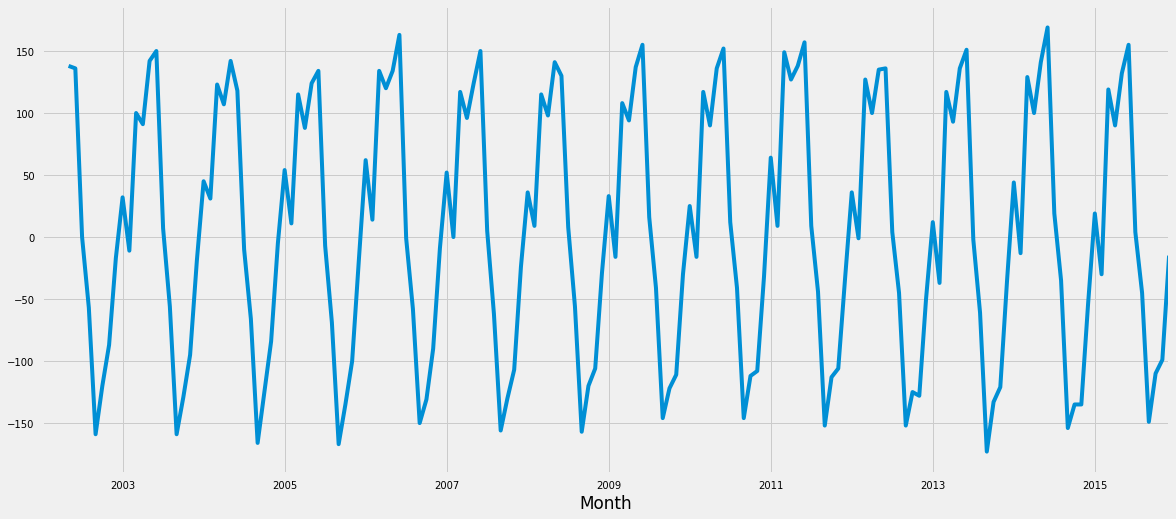

In [89]:
df_demand['Seasonal First Difference'].plot()

### Auto regressive model

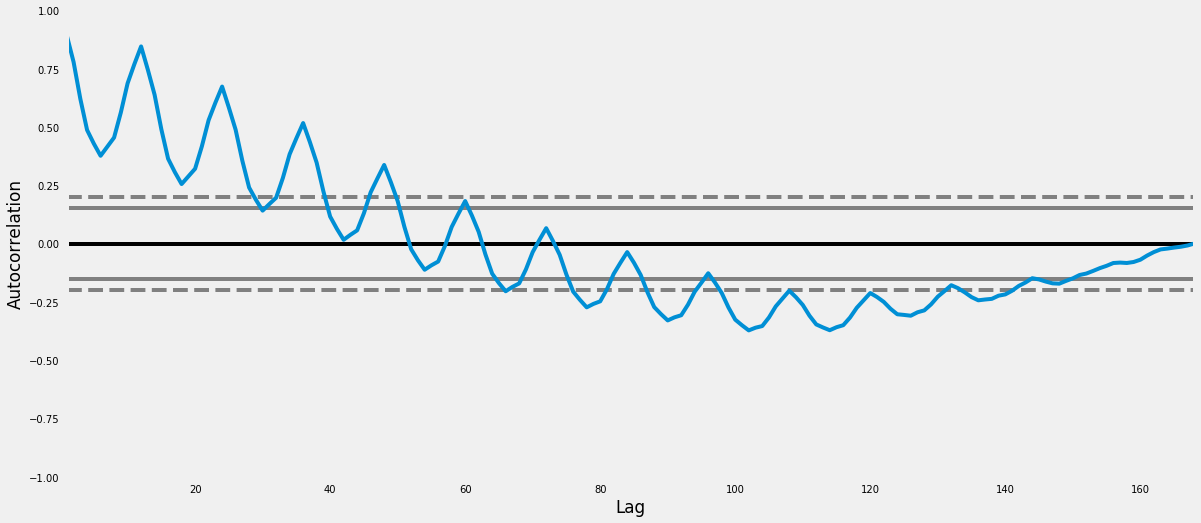

In [90]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_demand['pen_demamd'])
plt.show()

In [91]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df_demand['pen_demamd'],order=(1,1,1))
model_fit=model.fit()

### Model Summary

In [92]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.pen_demamd   No. Observations:                  167
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -873.331
Method:                       css-mle   S.D. of innovations             45.176
Date:                Fri, 12 Jun 2020   AIC                           1754.662
Time:                        17:10:22   BIC                           1767.134
Sample:                    02-01-2002   HQIC                          1759.724
                         - 12-01-2015                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.5417      3.874      0.398      0.691      -6.052       9.135
ar.L1.D.pen_demamd     0.3873      0.249      1.555      0.122      -0.101       0.875
ma.L1.D.pen_demamd    -0.3203      0.246     -1.301      0.195      -0.803       0.162
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5821           +0.0000j            2.5821            0.0000
MA.1            3.1218           +0.0000j            3.1218            0.0000
-----------------------------------------------------------------------------
"""

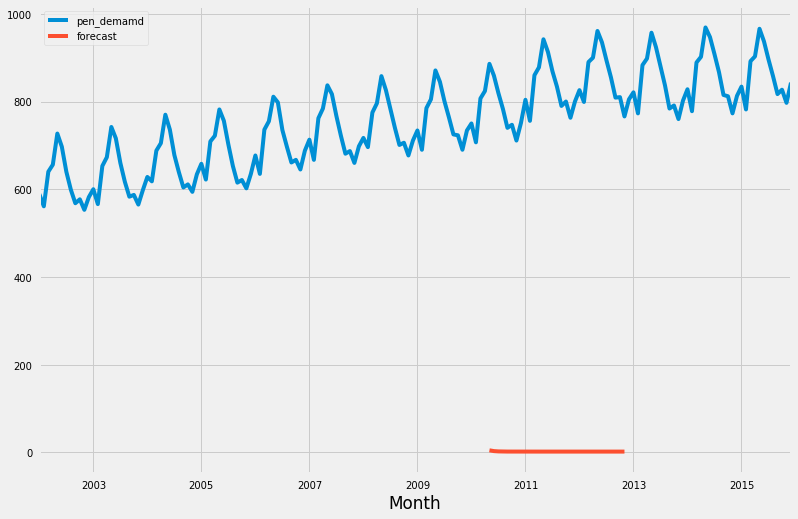

In [93]:
df_demand['forecast']=model_fit.predict(start=100,end=130,dynamic=True)
df_demand[['pen_demamd','forecast']].plot(figsize=(12,8))

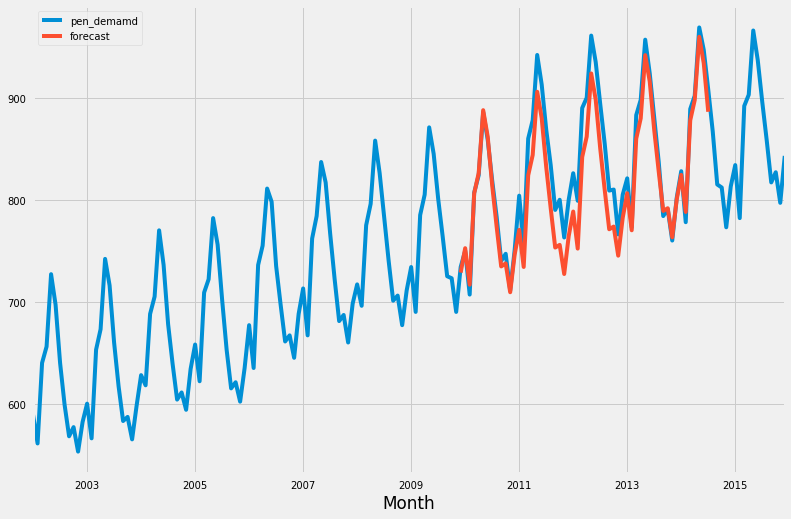

In [94]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_demand['pen_demamd'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df_demand['forecast']=results.predict(start=95,end=150,dynamic=True)
df_demand[['pen_demamd','forecast']].plot(figsize=(12,8))

In [96]:
df_demand.tail(5)

,pen_demamd,Sales First Difference,Seasonal First Difference,forecast
Month,,,,
2015-08-01,858,-38.0,-45.0,NaN
2015-09-01,817,-41.0,-149.0,NaN
2015-10-01,827,10.0,-110.0,NaN
2015-11-01,797,-30.0,-99.0,NaN
2015-12-01,843,46.0,-15.0,NaN


In [97]:
from pandas.tseries.offsets import DateOffset
future_dates=pd.date_range(start='1/2016', end='9/2018',freq= pd.offsets.MonthBegin() )
future_dates

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [98]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_demand.columns)
future_datest_df.sample(5)

,pen_demamd,Sales First Difference,Seasonal First Difference,forecast
2016-02-01,NaN,NaN,NaN,NaN
2017-11-01,NaN,NaN,NaN,NaN
2016-09-01,NaN,NaN,NaN,NaN
2018-07-01,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,NaN


### Forecasting result

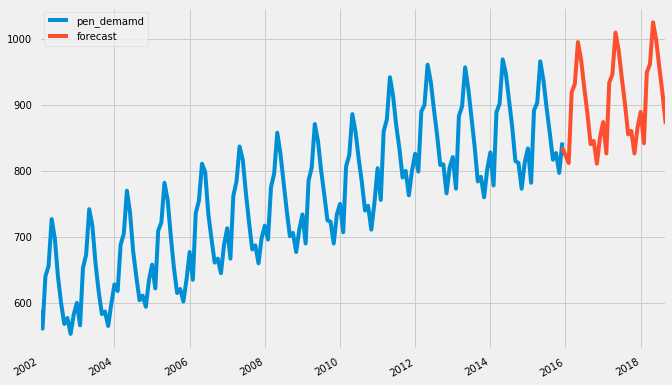

In [106]:
future_df=pd.concat([df_demand,future_datest_df])
future_df['forecast'] = results.predict(start = 167, end = 229, dynamic= True)  
future_df[['pen_demamd','forecast']].plot(figsize=(10,7))

## End of Notebook